In [39]:
%matplotlib inline

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

MULTILATERATION_METHOD = "2d"
# MULTILATERATION_METHOD = "3d"

LANG = "PL"
SMOOTHE = False
# LANG = "EN"
samples_dir = Path("data/movement_2")

# These can be overridden by environment.json
MOVEMENT=False
REF_POINT="P1"

DEL_ANCHORS = []
DEL_ANCHORS = ["0x6c0d"]
# DEL_ANCHORS = ["0x5601"]
# DEL_ANCHORS = ["0x26bd"]
# DEL_ANCHORS = ["0x5836"]

In [41]:
dpi = 600
width_inches = 6
height_inches = width_inches * 3/4 
FONT_SIZE = 12

In [42]:
# Try to get test environment conditions from JSON
import json

try:
    with open(samples_dir / "environment.json", "r") as file:
        settings = json.loads(file.read())
except:
    settings = dict()

if (TAG:=settings.get("tag")) is None:
    from data.points import TAG
if (ANCHORS := settings.get("anchors")) is None:
    from data.points import ANCHORS

In [43]:
class AccelerometerOrientation:
    x_sign: int
    global_x: str
    y_sign: int
    global_y: str

    def __init__(self, setting: str) -> None:
        """
        Module orientation
        The arrow should point the same way as the back of the module (accelerometer's +Z axis)
        <------x-------
               ^       |
              -y       |
                       |
         <+x     -x>   y
                       |
              +y       |
               v       v
        """
        match setting:
            case "+x":
                data = (1, "acc_z", -1, "acc_y")
            case "-x":
                data = (-1, "acc_z", 1, "acc_y")
            case "+y":
                data = (1, "acc_y", 1, "acc_z")
            case "-y":
                data = (-1, "acc_y", -1, "acc_z")
            case _:
                raise ValueError(setting)

        self.x_sign, self.global_x, self.y_sign, self.global_y = data

ACCELEROMETER_ORIENTATION = AccelerometerOrientation(settings.get("acc_orientation") or "-y")

In [44]:
folder_name = samples_dir.name.upper()

if folder_name.startswith("P"): 
    REF_POINT = samples_dir.name.upper()[:2]
else:
    MOVEMENT=True
    REF_POINT = settings.get("REF_POINT") or REF_POINT


filenames = [f for f in samples_dir.iterdir() if f.name.endswith(".csv")] if samples_dir.is_dir() else [samples_dir]
filenames.sort()
# filenames


In [45]:
dfs = [pd.read_csv(f, index_col=0) for f in filenames]
#Remove unwanted anchors
dfs = [df[~df["anchor"].isin(DEL_ANCHORS)] for df in dfs]

In [46]:
# Enforce same number of samples
if not MOVEMENT:
# if True:
    min_samples = min(len(df) for df in dfs)
    dfs = [df.head(min_samples) for df in dfs]

In [47]:
for df in dfs:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

dfs = [df[df.anchor.isin(ANCHORS.keys())] for df in dfs]
dfs = [df.set_index("timestamp") for df in dfs]

anchors = dfs[0]["anchor"].unique()

# Multilateration

In [48]:
from multilateration.solve import solve

solved_dfs = [solve(df, ANCHORS, MULTILATERATION_METHOD) for df in dfs]

# Smoothe
if SMOOTHE:
    for sdf in solved_dfs:
        sdf[["x","y"]] = sdf[["x", "y"]].rolling(window=3).mean().dropna()

In [49]:
solved_dfs = [df.merge(solved_df, on="timestamp")[
    [
        "timestamp",
        "acc_x",
        "acc_y",
        "acc_z",
        "x",
        "y",
        "radius",
    ]
] for df, solved_df in zip(dfs, solved_dfs)]

# Convert to metric, remove gravitation
for df in solved_dfs:
    df[["x", "y"]] /= 1000
    df[["acc_x", "acc_y", "acc_z"]] *= 9.80665
    df[["acc_x", "acc_y", "acc_z"]] -= df[["acc_x", "acc_y", "acc_z"]].head(5).mean()


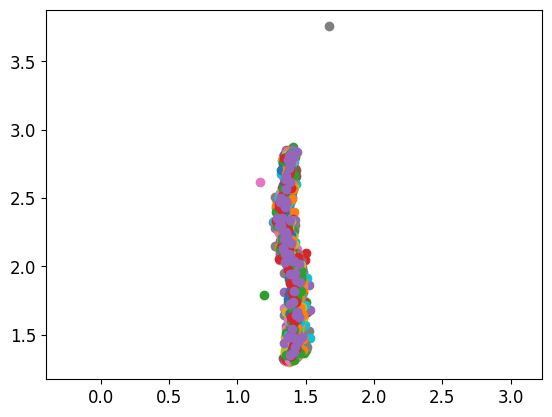

In [50]:
for df in solved_dfs:
    plt.scatter(df["x"], df["y"])
plt.axis("equal")
plt.show()

In [51]:
# Remove outliers
n_samples_before = sum(len(df) for df in solved_dfs)

def remove_outliers(df, columns, threshold=3):
    z_scores = np.abs((df[columns] - df[columns].mean()) / df[columns].std())
    df_no_outliers = df[(z_scores < threshold).all(axis=1)]
    return df_no_outliers

# Remove outliers from the DataFrame
solved_dfs = [remove_outliers(df, ['x', 'y']) for df in solved_dfs]
n_samples_after = sum(len(df) for df in solved_dfs)
display(f"Deleted {n_samples_before-n_samples_after} samples. Left {n_samples_after} out of {n_samples_before} samples.")

'Deleted 3 samples. Left 1830 out of 1833 samples.'

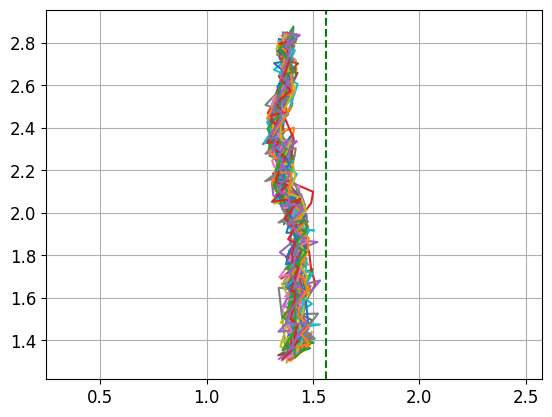

In [52]:
for df in solved_dfs:
    if MOVEMENT:
        plt.plot(df["x"], df["y"])
    else:
        plt.scatter(df["x"], df["y"])


if MOVEMENT:
    plt.axvline(TAG[REF_POINT][0] / 1000, color="green", linestyle="--")
else:
    plt.scatter(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, color="green")
plt.axis("equal")
plt.grid(True)
plt.show()

In [53]:
from math import sqrt
def p2p_dist(ax, ay, bx, by):
    return sqrt((bx - ax) ** 2 + (by - ay) ** 2)

def point_line_distance(x, y, a, b, c):
    return abs(a * x + b * y + c) / sqrt(a**2 + b**2)

In [54]:
if MOVEMENT:
    # ax + by + c = 0
    a = 1
    b = 0
    c = - TAG[REF_POINT][0] / 1000
    calc_dist = lambda x: point_line_distance(x[0], x[1], a, b, c)
else:
    calc_dist = lambda x: p2p_dist(x[0], x[1], TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000)

for df in solved_dfs:
    df["error"] = df[["x", "y"]].apply(calc_dist, axis=1)
    

# Kalman filter

In [55]:
def kalman_step(x, P, measurement, R, Q, F, H):
    # Predict
    x = F * x
    P = F * P * F.T + Q

    # Update
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R 
    K = P * H.T * S.I
    x = x + K * y
    I = np.matrix(np.eye(F.shape[0])) 
    P = (I - K * H) * P

    return x, P

In [56]:
kalman_dfs = []
for df in solved_dfs:
    dt = df["timestamp"].diff().mean().to_pytimedelta().microseconds / 10**6

    F = np.matrix(
        [[1, 0, dt**2 / 2, 0], [0, 1, 0, dt**2 / 2], [0, 0, 1, 0], [0, 0, 0, 1]]
    )
    H = np.matrix(np.eye(4))

    # Q = np.matrix(np.diag([0.0001, 0.0001, 0.01, 0.00000001]))
    # Q = np.matrix(np.diag([0.0001, 0.0001, 0.01, 0.01]))
    # Q = np.matrix(np.diag([0.001, 0.001, 0.001, 0.001]))
    Q = np.matrix(np.diag([0.0002, 0.0002, 0.0001, 0.0001])) # best one
    if MOVEMENT:
        R = np.matrix(np.eye(4) * 2e-4)
    else:
        R = np.matrix(
            np.diag(
                [
                    df["x"].std() ** 2,
                    df["y"].std() ** 2,
                    df[ACCELEROMETER_ORIENTATION.global_x].std() ** 2,
                    df[ACCELEROMETER_ORIENTATION.global_y].std() ** 2,
                ]
            )
        )

    P = np.matrix(np.eye(4)) * 100
    x = np.matrix("0. 0. 0. 0.").T


    # Filter
    filtered = []
    for _, measurement in df[
        [
            "x",
            "y",
            ACCELEROMETER_ORIENTATION.global_x,
            ACCELEROMETER_ORIENTATION.global_y,
        ]
    ].iterrows():
        measurement = measurement.to_list()
        measurement = [
            measurement[0],  # x
            measurement[1],  # y
            ACCELEROMETER_ORIENTATION.x_sign * measurement[2],  # x
            ACCELEROMETER_ORIENTATION.y_sign * measurement[3],  # y
        ]
        x, P = kalman_step(x, P, measurement, R, Q, F, H)
        filtered.append(x.tolist())

    filtered_pos = [[x[0], y[0]] for (x, y, _, _) in filtered]
    kalman_dfs.append(pd.DataFrame(filtered_pos, columns=["x", "y"]))

len(kalman_dfs)

35

In [57]:
for df in kalman_dfs:
    df["error"] = df.apply(calc_dist, axis=1)

In [58]:
import plotly.express as px
import plotly.graph_objects as go

# for i, df in enumerate(solved_dfs):
#     plt.plot(df["error"], label=i)
# plt.legend()
# plt.show()

data = {i: df for i, df in enumerate(solved_dfs)}
fig = go.Figure()

for i in data:
    fig = fig.add_trace(go.Line(y = data[i]["error"], 
                                   name = i))
fig.show()

/home/piotr/Documents/mgr/uwb-rs/data-processing/.venv/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [59]:
# All error Kalman vs no Kalman

# for df_k, df_u in zip(kalman_dfs, solved_dfs):
#     plt.plot(df_k["error"], "-o", label="Kalman")
#     plt.plot(df_u["error"], "-o", label="UWB")
#     plt.legend()
#     plt.ylabel("Absolute error [m]")
#     plt.xlabel("Sample index")
#     plt.grid(True)
#     plt.show()

# Mean

In [60]:
all_kalman = pd.concat(kalman_dfs, ignore_index=True)
all_uwb = pd.concat(solved_dfs, ignore_index=True)

In [61]:
kalman = pd.concat(kalman_dfs)
kalman = kalman.groupby(kalman.index).mean()

solved = pd.concat(solved_dfs)
solved = solved[["x", "y", "error"]]
solved = solved.groupby(solved.index).mean()

dt = all_uwb["timestamp"].diff().mean().to_pytimedelta().microseconds / 10**6

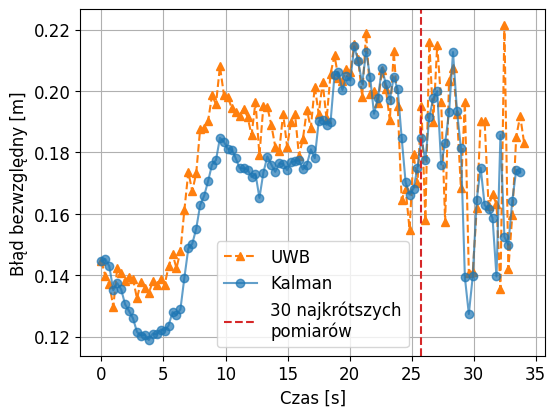

In [85]:
# def gen():
#     last = 1
#     while True:
#         try:
#             last = next(solved_dfs[0]["timestamp"].diff().fillna(0).to_numpy())
#             yield last
#         except StopIteration:
#             yield last
# g = gen()
# x = [next(g) for _ in range(len(kalman["error"]))]
# x_k = x.copy()

x = [i * dt for i in range(len(solved["error"]))]
x_k = [i * dt for i in range(len(kalman["error"]))]

plt.rcParams['font.size'] = FONT_SIZE
plt.plot(x, solved["error"], "--^", label="UWB", c="tab:orange")
plt.plot(x_k, kalman["error"], "-o", label="Kalman", c="tab:blue", alpha=0.7)

shortest_meas_marker = 30
if MOVEMENT and len(solved_dfs) > shortest_meas_marker:
    n_of_samples = [len(df) for df in solved_dfs]
    n_of_samples.sort()
    end_of_30th_sample = n_of_samples[shortest_meas_marker]
    plt.axvline(x[end_of_30th_sample], ls="--", c="tab:red", label=f"{shortest_meas_marker} shortest measurements" if LANG=="EN" else f"{shortest_meas_marker} najkrótszych\npomiarów")


plt.legend()
plt.ylabel("Absolute error [m]" if LANG=="EN" else "Błąd bezwzględny [m]")
plt.xlabel("Time [s]" if LANG=="EN" else "Czas [s]")
plt.grid(True)
plt.gcf().set_size_inches(width_inches, height_inches)
plt.savefig(f"plots_output/errors_over_time_{str(samples_dir).replace('/', '_')}_{REF_POINT}" 
            + (f"_deleted_{'_'.join(DEL_ANCHORS)}" if DEL_ANCHORS else "") 
            + ".png",
             dpi=dpi, bbox_inches='tight')
plt.show()

data/movement_2/2023-07-07-17:40:46.444178move2-1.csv


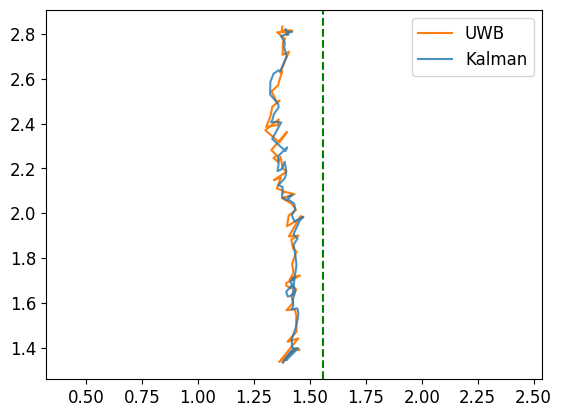

data/movement_2/2023-07-07-17:42:06.993385move2-2.csv


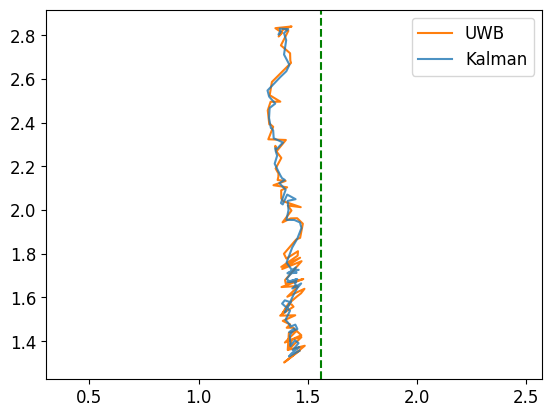

data/movement_2/2023-07-07-17:43:26.951057move2-3.csv


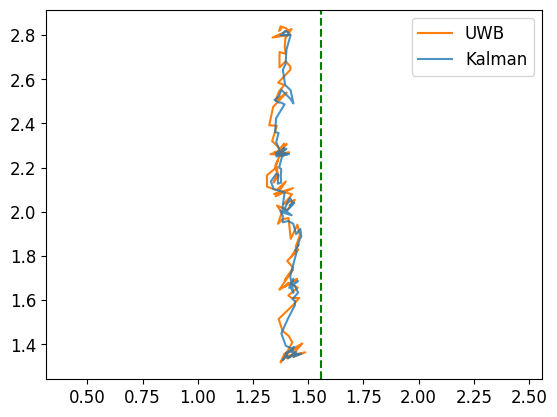

In [63]:
# Trace/scatter for every data set
n_plots = 3
for filename, df, kdf in zip(filenames[:n_plots], solved_dfs[:n_plots], kalman_dfs[:n_plots]):
    if MOVEMENT:
        # df.x = df.x.rolling(window=3).mean()
        # df.y = df.y.rolling(window=3).mean()
        # x = kdf.x.rolling(window=3).mean()
        # y = kdf.y.rolling(window=3).mean()
        plt.plot(df.x, df.y, "-", color="tab:orange", label="UWB")
        plt.plot(kdf.x, kdf.y, "-", color="tab:blue", label="Kalman", alpha=0.8)
        plt.axvline(TAG[REF_POINT][0] / 1000, color="g", linestyle="--")
    else:
        plt.scatter(kdf.x, kdf.y, color="blue", label="Kalman")
        plt.scatter(df.x, df.y, color="orange" ,label="UWB")
        plt.plot(TAG[REF_POINT][0]/1000, TAG[REF_POINT][1]/1000, "g1")
    plt.axis("equal")
    plt.legend()
    print(filename)
    plt.show()

In [64]:
import seaborn as sns

x_y_comparison_df = pd.concat([all_kalman.copy().assign(name="Kalman"), all_uwb[["x", "y", "error"]].copy().assign(name="UWB")])

In [65]:

# # plt.title("Bivariate distribution of positioning results.")
# if MOVEMENT:
#     sns.jointplot(
#         data=x_y_comparison_df,
#         x="x",
#         y="y",
#         hue="name",
#         # kind="kde",
#         # bw_adjust=0.9,
#     )
#     # for df in kalman_dfs:
#     #     plt.plot(df.x, df.y, color="blue")
#     # for df in solved_dfs:
#     #     plt.plot(df.x, df.y, color="orange")
#     plt.axvline(TAG[REF_POINT][0] / 1000, color="g", linestyle="--")
# else:    
#     sns.jointplot(
#         data=x_y_comparison_df,
#         x="x",
#         y="y",
#         hue="name",
#         kind="kde",
#         levels=[0.1, 0.3, 0.5, 0.7, 0.9],
#     )
#     plt.plot(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, "go")
# ax = plt.gca()
# plt.xlabel("x [m]")
# plt.ylabel("y [m]")
# ax.get_legend().set_title("")
# plt.grid()
# plt.gcf().set_size_inches(width_inches, width_inches)
# plt.savefig(f"plots_output/kde_{str(samples_dir).replace('/', '_')}_{REF_POINT}.png", dpi=dpi, bbox_inches='tight')
# plt.show()

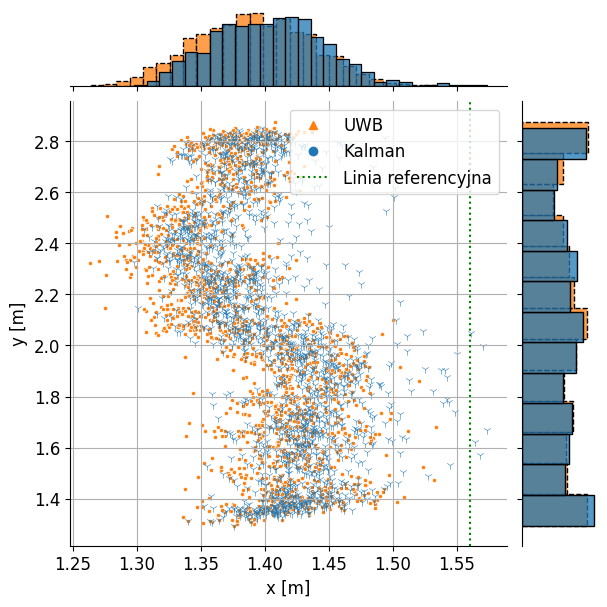

In [66]:
plt.rcParams['font.size'] = FONT_SIZE
g = sns.JointGrid()
if not MOVEMENT:
    # Main plot
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            y="y",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyles="dashed",
            label="UWB",
            ax=g.ax_joint,
            color="tab:orange",
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            x="x",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            label="Kalman",
            ax=g.ax_joint
        )
    g.ax_joint.plot(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, "go")

    # Top marginal (x)
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            ax=g.ax_marg_x
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            x="x",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            label="Kalman",
            ax=g.ax_marg_x
        )

    # Right marginal (y)
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            y="y",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            ax=g.ax_marg_y
        )
    sns.kdeplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            label="Kalman",
            color="tab:blue",
            ax=g.ax_marg_y
        )
    custom_legend_handles = [plt.Line2D([], [], linestyle='--', color='tab:orange', label='UWB'),
                        plt.Line2D([], [], linestyle='-', color='tab:blue', label='Kalman'),
                        plt.Line2D([], [], linestyle='None', marker="o", color="g", label="Reference point"  if LANG=="EN" else "Punkt referencyjny")]
else:
    # Main plot
    sns.scatterplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            y="y",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            # linestyles="dashed",
            label="UWB",
            ax=g.ax_joint,
            marker=".",
            color="tab:orange",
            # sort=False,
        )
    sns.scatterplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            x="x",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            alpha=0.8,
            marker="1",
            label="Kalman",
            ax=g.ax_joint,
            # sort=False,
        )
    g.ax_joint.axvline(TAG[REF_POINT][0] / 1000, linestyle="dotted", color="g")

    # Top marginal (x)
    sns.histplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            x="x",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            ax=g.ax_marg_x
        )
    sns.histplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            x="x",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            color="tab:blue",
            label="Kalman",
            ax=g.ax_marg_x
        )

    # Right marginal (y)
    sns.histplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "UWB"],
            y="y",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            linestyle="dashed",
            label="UWB",
            color="tab:orange",
            ax=g.ax_marg_y
        )
    sns.histplot(
            data=x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"],
            y="y",
            # levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            label="Kalman",
            color="tab:blue",
            ax=g.ax_marg_y
        )

    custom_legend_handles = [plt.Line2D([], [], linestyle='', marker="^", color='tab:orange', label='UWB'),
                            plt.Line2D([], [], linestyle='', marker="o", color='tab:blue', label='Kalman'),
                            plt.Line2D([], [], linestyle='dotted', color="g", label="Reference line"  if LANG=="EN" else "Linia referencyjna")]
custom_legend_labels = [handle.get_label() for handle in custom_legend_handles]

# Add the custom legend to the plot
g.ax_joint.legend(handles=custom_legend_handles, labels=custom_legend_labels)#, loc='upper right')
g.ax_joint.set_xlabel("x [m]")
g.ax_joint.set_ylabel("y [m]")
g.ax_joint.grid()
plt.gcf().set_size_inches(width_inches, width_inches)
plt.savefig(f"plots_output/kde_{str(samples_dir).replace('/', '_')}_{REF_POINT}"
            + (f"_deleted_{'_'.join(DEL_ANCHORS)}" if DEL_ANCHORS else "") 
            + ".png"
            , dpi=dpi, bbox_inches='tight')
plt.show()


In [67]:
# if MOVEMENT:
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "UWB"]
#     plt.plot(_df["x"], _df["y"], label="UWB")
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"]
#     plt.plot(_df["x"], _df["y"], label="Kalman")
# else:
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "UWB"]
#     plt.scatter(_df["x"], _df["y"], label="UWB")
#     _df = x_y_comparison_df[x_y_comparison_df["name"] == "Kalman"]
#     plt.scatter(_df["x"], _df["y"], label="Kalman")


# if MOVEMENT:
#     plt.axvline(TAG[REF_POINT][0] / 1000, color="green", linestyle="--")
# else:
#     plt.scatter(TAG[REF_POINT][0] / 1000, TAG[REF_POINT][1] / 1000, color="green")
# plt.axis("equal")
# plt.xlabel("x [m]")
# plt.ylabel("y [m]")
# plt.legend()
# plt.grid(True)
# plt.show()

# RMSE

In [68]:
errors = pd.concat(
    [all_kalman["error"], all_uwb["error"]],
    axis=1,
    keys=["Kalman (UWB+accelerometer)"  if LANG=="EN" else "Kalman (UWB i akcelerometr)", "UWB"],
)
rmse = np.sqrt(errors.apply(lambda x: x**2, axis=1).mean())

display(f"N. of series: {len(filenames)}; N. of samples: {len(all_uwb)}")
rmse, f"Poprawa {(rmse[1] - rmse[0]) / rmse[1]*100:.1f}%"

'N. of series: 35; N. of samples: 1830'

(Kalman (UWB i akcelerometr)    0.162135
 UWB                            0.175091
 dtype: float64,
 'Poprawa 7.4%')

# Standard deviation

In [69]:
(e_std:=errors.std()) , f"Poprawa {(e_std[1] - e_std[0]) / e_std[1]*100:.1f}%"

(Kalman (UWB i akcelerometr)    0.043110
 UWB                            0.044527
 dtype: float64,
 'Poprawa 3.2%')

# RMSE when ref point = mean point

In [70]:
if MOVEMENT:
    c = - all_kalman.x.mean()
    calc_dist_kalman = lambda x: point_line_distance(x[0], x[1], a, b, c)
    calc_dist_uwb = lambda x: point_line_distance(x[0], x[1], a, b, c)
else:
    ref_point_kalman = (all_kalman.x.mean(), all_kalman.y.mean())
    ref_point_uwb = (all_uwb.x.mean(), all_uwb.y.mean())
    calc_dist_kalman = lambda x: p2p_dist(x[0], x[1], *ref_point_kalman)
    calc_dist_uwb = lambda x: p2p_dist(x[0], x[1], *ref_point_uwb)

In [71]:
for df in kalman_dfs:
    df["error"] = df[["x","y"]].apply(calc_dist_kalman, axis=1)

for df in solved_dfs:
    df["error"] = df[["x","y"]].apply(calc_dist_uwb, axis=1)

In [72]:
all_kalman_ref = pd.concat(kalman_dfs, ignore_index=True)
all_uwb_ref = pd.concat(solved_dfs, ignore_index=True)

errors = pd.concat(
    [all_kalman_ref["error"], all_uwb_ref["error"]],
    axis=1,
    keys=["Kalman (UWB+accelerometer)"  if LANG=="EN" else "Kalman (UWB i akcelerometr)", "UWB"],
)
rmse = np.sqrt(errors.apply(lambda x: x**2, axis=1).mean())

rmse, rmse.diff()

(Kalman (UWB i akcelerometr)    0.043246
 UWB                            0.046396
 dtype: float64,
 Kalman (UWB i akcelerometr)        NaN
 UWB                            0.00315
 dtype: float64)

# RMSE with line fitting

In [73]:
if MOVEMENT:
    for df, kdf in zip(solved_dfs, kalman_dfs):
        # Swap x and y to have small "a" coefficient values
        x = df['y'].values
        y = df['x'].values


        k_x = kdf["y"].values
        k_y = kdf["x"].values

        # Calculating the coefficients of the line using least squares method
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]

        # Creating the line equation string
        # line_equation = f'y = {m:.2f}x + {c:.2f}'

        # Generating the predicted y-values for the line
        y_pred = m * x + c

        # Calculate errors
        # ax + by + c = 0
        a = m
        b = -1
        df["fitted_error"] = [point_line_distance(_x, _y, a, b, c) for _x,_y in zip(x,y)]
        kdf["fitted_error"] = [point_line_distance(_x, _y, a, b, c) for _x,_y in zip(k_x,k_y)]

        # # Plotting the original data points and the fitted line
        # plt.plot(y,x, label='UWB')
        # plt.plot(k_y, k_x, label='Kalman')
        # plt.plot(y_pred, x, 'r', label='Fitted Line')
        # plt.xlabel('x')
        # plt.ylabel('y')
        # # plt.title('Line Fitting')
        # plt.axis("equal")   
        # plt.legend()

        # # Displaying the line equation and the plot
        # # print('Line Equation:', line_equation)
        # plt.show()


    all_kalman_fitted = pd.concat(kalman_dfs, ignore_index=True)
    all_uwb_fitted = pd.concat(solved_dfs, ignore_index=True)

    errors = pd.concat(
        [all_kalman_fitted["fitted_error"], all_uwb_fitted["fitted_error"]],
        axis=1,
        keys=["Kalman (UWB+accelerometer)" if LANG=="EN" else "Kalman (UWB i akcelerometr)", "UWB"],
    )
    rmse = np.sqrt(errors.apply(lambda x: x**2, axis=1).mean())

    display(rmse, rmse.diff())

Kalman (UWB i akcelerometr)    0.037837
UWB                            0.035766
dtype: float64

Kalman (UWB i akcelerometr)         NaN
UWB                           -0.002072
dtype: float64

# Movement curvature comparison

In [74]:
if MOVEMENT:
    def calculate_curvature(x, y):
        dx = np.gradient(x)
        dy = np.gradient(y)
        d2x = np.gradient(dx)
        d2y = np.gradient(dy)

        curvature = (dx * d2y - dy * d2x) / (dx**2 + dy**2)**(3/2)
        return curvature

    def average_curvature(x, y):
        curvature = calculate_curvature(x, y)
        avg_curvature = np.mean(np.abs(curvature))
        return avg_curvature

    def path_is_smoother(path1, path2, path1_name="Path 1", path2_name="Path 2"):
        x1, y1 = path1["x"], path1["y"]
        x2, y2 = path2["x"], path2["y"]

        smooth_path_curvature_1 = average_curvature(x1, y1)
        smooth_path_curvature_2 = average_curvature(x2, y2)

        # if smooth_path_curvature_1 < smooth_path_curvature_2:
            # print(f"{path1_name} is smoother than {path2_name}.")
        # else:
            # print(f"{path2_name} is smoother than {path1_name}.")
        return (smooth_path_curvature_1, smooth_path_curvature_2)

In [75]:
if MOVEMENT:
    results = []
    for udf, kdf in zip(solved_dfs, kalman_dfs):
        pc_uwb, pc_k = path_is_smoother(udf, kdf, "UWB", "Kalman")
        results.append(pc_k < pc_uwb)
    print(f"Percentage of smoother Kalman paths: {results.count(True)/len(results)}")



Percentage of smoother Kalman paths: 0.45714285714285713


# Vector field

[(1.0, 2.0), (1.0, 3.5)]

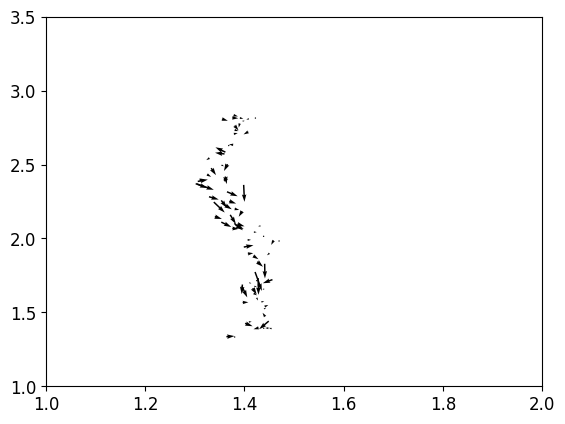

In [76]:
fig, ax = plt.subplots()
ax.quiver(solved_dfs[0].x, solved_dfs[0].y, kalman_dfs[0].x - solved_dfs[0].x, kalman_dfs[0].y - solved_dfs[0].y, angles="xy", scale=2, width=0.003)
ax.set(xlim=(1, 2), ylim=(1, 3.5))